In [2]:
import torch
import torchvision
from torchvision import models

import cv2
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('yolov5')

from yolov5 import utils
import keras_ocr

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

display = utils.notebook_init()

YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.6 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3902MiB)


Setup complete ✅ (16 CPUs, 15.0 GB RAM, 200.4/219.4 GB disk)


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [4]:
path = "Data/"
dev_seen_data= pd.read_json(path+'dev_seen.jsonl',lines=True)
dev_unseen_data= pd.read_json(path+'dev_unseen.jsonl',lines=True)
test_seen_data=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen_data=pd.read_json(path+'test_unseen.jsonl',lines=True)
train_data=pd.read_json(path+'train.jsonl',lines=True)

In [5]:
# Get frequency of each label
DEV_SEEN = dev_seen_data['label'].value_counts()
DEV_UNSEEN = dev_unseen_data['label'].value_counts()
TEST_SEEN = test_seen_data['label'].value_counts()
TEST_UNSEEN = test_unseen_data['label'].value_counts()
TRAIN = train_data['label'].value_counts()

print(f"Dev Seen: {DEV_SEEN}")
print(f"Dev Unseen: {DEV_UNSEEN}")
print(f"Test Seen: {TEST_SEEN}")
print(f"Test Unseen: {TEST_UNSEEN}")
print(f"Train: {TRAIN}")

Dev Seen: label
0    253
1    247
Name: count, dtype: int64
Dev Unseen: label
0    340
1    200
Name: count, dtype: int64
Test Seen: label
0    510
1    490
Name: count, dtype: int64
Test Unseen: label
0    1250
1     750
Name: count, dtype: int64
Train: label
0    5481
1    3019
Name: count, dtype: int64


In [6]:
data = pd.concat([train_data,test_seen_data,test_unseen_data,dev_seen_data,dev_unseen_data])
data1 = data.drop_duplicates(subset=['img'])

In [5]:
data1

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
135,82054,img/82054.png,0,puzzle level expert
136,13749,img/13749.png,0,it's amazing how animal bodies and the human b...
137,85067,img/85067.png,0,rare image of a worker picking cotton
138,20541,img/20541.png,0,caught me cat and monkey today! this


In [10]:
data1 = data1.sample(n=1000, random_state=1)
data1.to_csv('Data/1000_rand.csv', index=False)

In [7]:
data1 = pd.read_csv('Data/1000_rand.csv')

# YOLOv5

In [12]:
path2 = 'Data/'
objects = {}
done = 0

accumulated_data = pd.DataFrame(columns=['img', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'])
global_csv_path = path2 + 'yolov5_global_results.csv'

accumulated_data.to_csv(global_csv_path, mode='w', index=False)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.to(device)
model.eval()

with torch.no_grad():
   for each in tqdm(data1['img']):
     img_path = path2 + each
     results = model(img_path)
     object1 = results.pandas().xyxy[0]
     object1['img'] = img_path
     accumulated_data = pd.concat([accumulated_data, object1], ignore_index=True)

     if done % 100 == 0:
       accumulated_data.to_csv(global_csv_path, mode='a', index=False, header=False)
       accumulated_data = pd.DataFrame(columns=['img', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'])

     done += 1

if not accumulated_data.empty:
    accumulated_data.to_csv(global_csv_path, mode='a', index=False, header=False)

requirements: Ultralytics requirement ['setuptools>=65.5.1'] not found, attempting AutoUpdate...


Using cache found in /home/sanyam/.cache/torch/hub/ultralytics_yolov5_master
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.0.32 requires setuptools~=60.2.0, but you have setuptools 69.0.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 4.9 MB/s eta 0:00:003.8 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0

requirements: AutoUpdate success ✅ 3.8s, installed 1 package: ['setuptools>=65.5.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v7.0-253-g63555c8 Python-3.10.6 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3902MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
100%|██████████| 1000/1000 [00:43<00:00, 23.01it/s]


In [13]:
# Path to the CSV file and directory for saving images
csv_file = 'Data/yolov5_global_results.csv'
save_dir = 'Data/YOLOv5_Results/'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    for file in os.listdir(save_dir):
        os.remove(os.path.join(save_dir, file))

# Read the CSV file
df = pd.read_csv(csv_file)

# Group by filename
grouped = df.groupby('img')

for filename, data in tqdm(grouped):
    # Get the image path
    img_path = data['img'].iloc[0]

    # Read the image
    image = cv2.imread(img_path)

    # Iterate over the rows
    for idx, row in data.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        label = row['name']

        # Draw the bounding box
        start_point = (int(xmin), int(ymin))
        end_point = (int(xmax), int(ymax))
        color = (255, 0, 0)  # Blue color in BGR
        thickness = 1
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

        # Put the label
        cv2.putText(image, label, (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Save the image
    save_path = os.path.join(save_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, image)

100%|██████████| 913/913 [00:19<00:00, 46.83it/s]


# Faster RCNN

In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [9]:
path2 = 'Data/'
objects = {}
done = 0

accumulated_data = pd.DataFrame(columns=['img', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'])
global_csv_path = path2 + 'faster_rcnn_global_results.csv'

accumulated_data.to_csv(global_csv_path, mode='w', index=False)

model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model.to(device)
model.eval()

with torch.no_grad():
    for each in tqdm(data1['img']):
        img_path = path2 + each
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img / 255.).permute(2, 0, 1).float().to(device)
        img = img.unsqueeze(0)
        results = model(img)
        object1 = results[0]
        boxes = object1['boxes'].cpu().detach().numpy()
        labels = object1['labels'].cpu().detach().numpy()
        scores = object1['scores'].cpu().detach().numpy()

        # Process each detection and append to DataFrame
        for box, label, score in zip(boxes, labels, scores):
            if score < 0.50:
                continue
            xmin, ymin, xmax, ymax = box
            class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
            new_row = {'img': img_path, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax, 'confidence': score, 'class': label, 'name': class_name}
            # Convert to Pandas data frame, append to accumulated data
            object1 = pd.DataFrame(new_row, index=[0])
            accumulated_data = pd.concat([accumulated_data, object1], ignore_index=True)

        if done % 100 == 0:
            accumulated_data.to_csv(global_csv_path, mode='a', index=False, header=False)
            accumulated_data = pd.DataFrame(columns=['img', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'])

        done += 1

# After the loop, append any remaining data to the CSV file
if not accumulated_data.empty:
    accumulated_data.to_csv(global_csv_path, mode='a', index=False, header=False)

# 7m 56s

100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


In [10]:
# Path to the CSV file and directory for saving images
csv_file = 'Data/faster_rcnn_global_results.csv'
save_dir = 'Data/Faster_RCNN_Results/'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    for file in os.listdir(save_dir):
        os.remove(os.path.join(save_dir, file))

# Read the CSV file
df = pd.read_csv(csv_file)

# Group by filename
grouped = df.groupby('img')

for filename, data in tqdm(grouped):
    # Get the image path
    img_path = data['img'].iloc[0]

    # Read the image
    image = cv2.imread(img_path)

    # Iterate over the rows
    for idx, row in data.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        label = row['name']

        # Draw the bounding box
        start_point = (int(xmin), int(ymin))
        end_point = (int(xmax), int(ymax))
        color = (255, 0, 0)  # Blue color in BGR
        thickness = 1
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

        # Put the label
        cv2.putText(image, label, (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Save the image
    save_path = os.path.join(save_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, image)

100%|██████████| 958/958 [00:19<00:00, 49.51it/s]


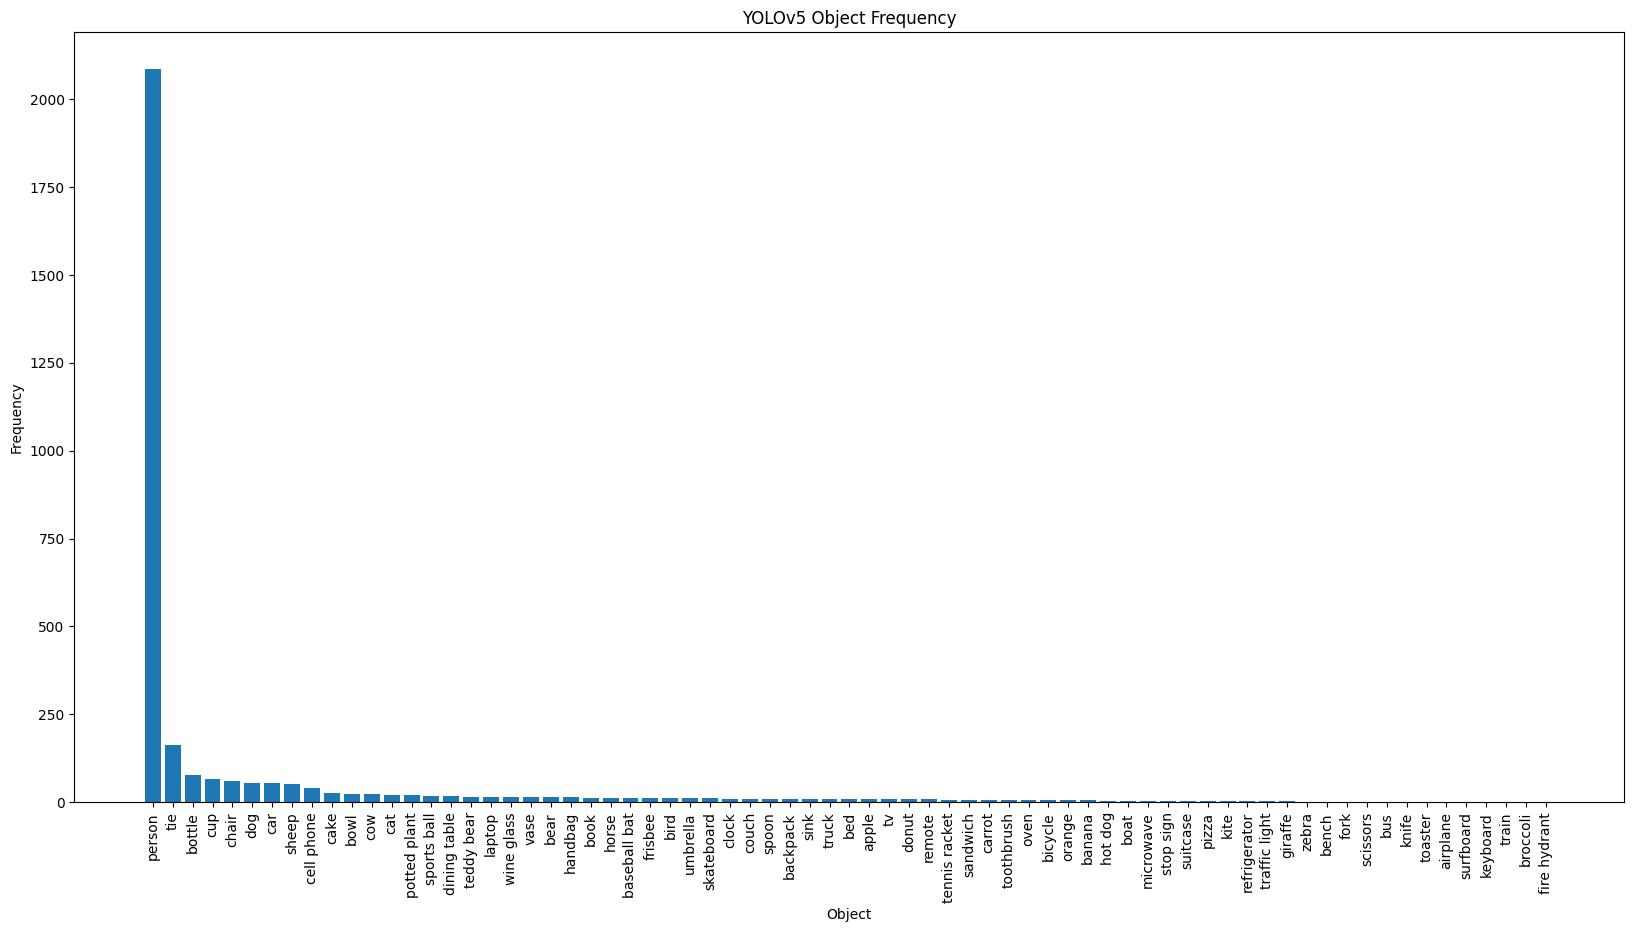

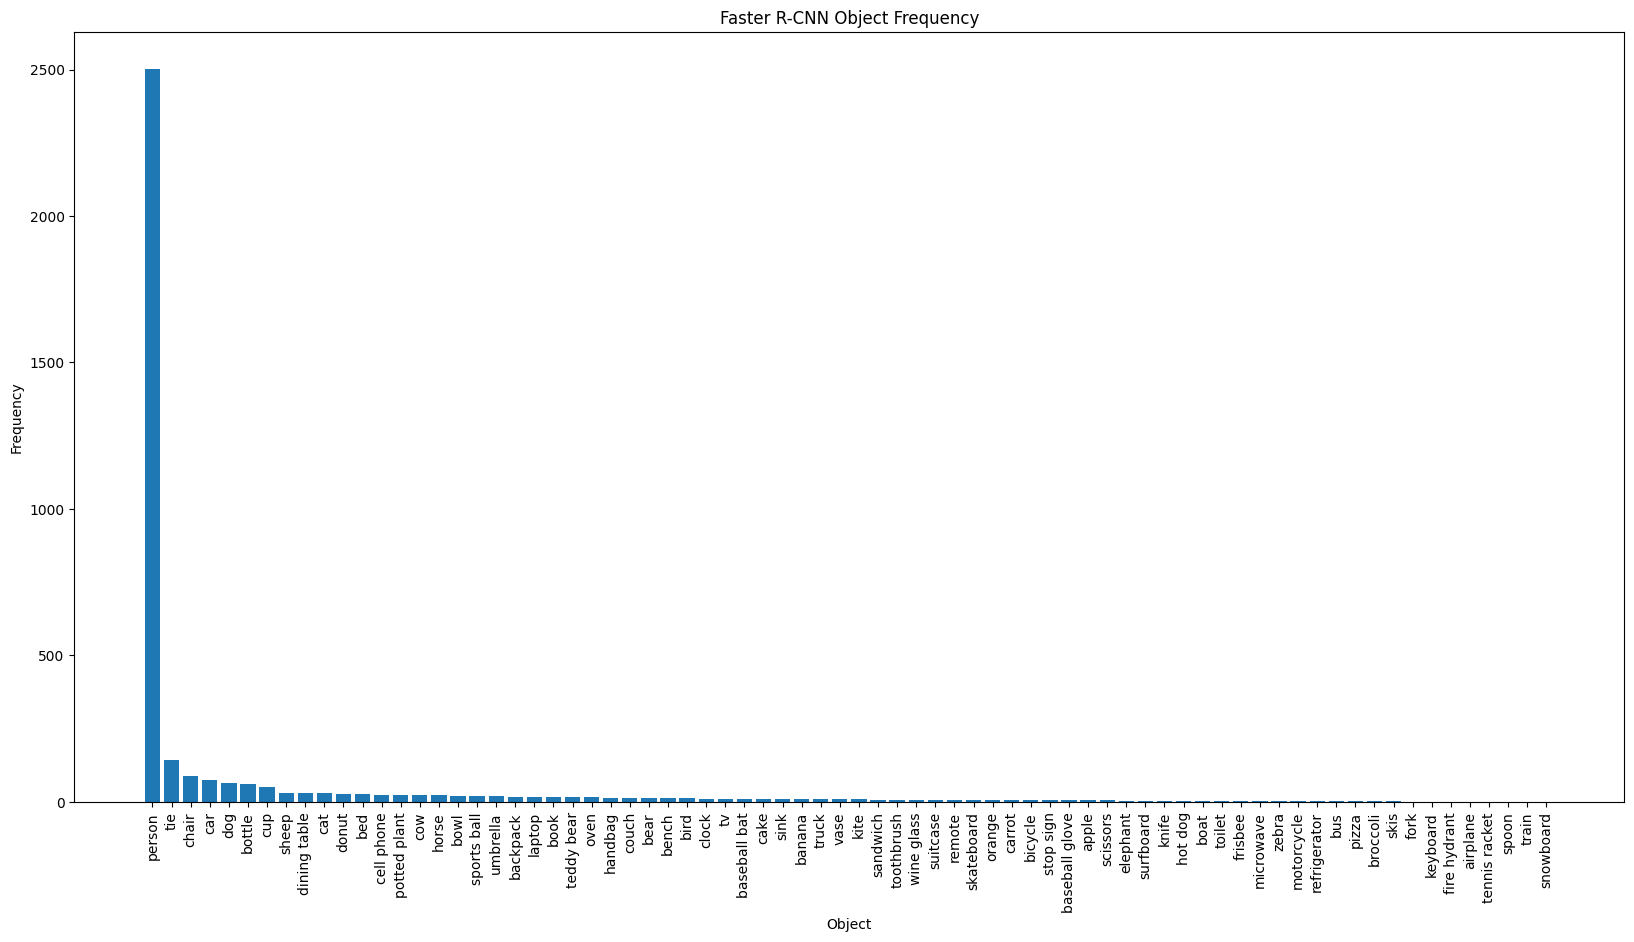

In [11]:
yolov5_results = 'Data/yolov5_global_results.csv'
df = pd.read_csv(yolov5_results)
object_frequency = df['name'].value_counts()
# Plot the object frequency
plt.figure(figsize=(20, 10))
plt.bar(object_frequency.index, object_frequency.values)
plt.xticks(rotation=90)
plt.xlabel('Object')
plt.ylabel('Frequency')
plt.title('YOLOv5 Object Frequency')
plt.show()

faster_rcnn_results = 'Data/faster_rcnn_global_results.csv'
df = pd.read_csv(faster_rcnn_results)
object_frequency = df['name'].value_counts()
# Plot the object frequency
plt.figure(figsize=(20, 10))
plt.bar(object_frequency.index, object_frequency.values)
plt.xticks(rotation=90)
plt.xlabel('Object')
plt.ylabel('Frequency')
plt.title('Faster R-CNN Object Frequency')
plt.show()

In [12]:
# Replace with the correct paths to your CSV files
yolov5_results = 'Data/yolov5_global_results.csv'
faster_rcnn_results = 'Data/faster_rcnn_global_results.csv'

# Read and process YOLOv5 results
df_yolov5 = pd.read_csv(yolov5_results)
object_frequency_yolov5 = df_yolov5['name'].value_counts()

# Read and process Faster R-CNN results
df_faster_rcnn = pd.read_csv(faster_rcnn_results)
object_frequency_faster_rcnn = df_faster_rcnn['name'].value_counts()

# Combine the two Series into one DataFrame for comparison
combined_df = pd.DataFrame({'YOLOv5': object_frequency_yolov5, 'Faster R-CNN': object_frequency_faster_rcnn}).fillna(0)

# Print the frequencies for each unique word in both models
for idx, row in combined_df.iterrows():
    print(f"{idx}: {row['YOLOv5']} {row['Faster R-CNN']}")

airplane: 1.0 1.0
apple: 9.0 6.0
backpack: 9.0 18.0
banana: 5.0 9.0
baseball bat: 12.0 10.0
baseball glove: 0.0 6.0
bear: 14.0 14.0
bed: 9.0 27.0
bench: 2.0 14.0
bicycle: 6.0 7.0
bird: 11.0 13.0
boat: 4.0 4.0
book: 13.0 16.0
bottle: 78.0 62.0
bowl: 24.0 21.0
broccoli: 1.0 2.0
bus: 1.0 3.0
cake: 27.0 10.0
car: 54.0 75.0
carrot: 6.0 7.0
cat: 21.0 29.0
cell phone: 41.0 24.0
chair: 59.0 87.0
clock: 10.0 11.0
couch: 10.0 15.0
cow: 22.0 23.0
cup: 66.0 50.0
dining table: 18.0 30.0
dog: 56.0 66.0
donut: 8.0 28.0
elephant: 0.0 5.0
fire hydrant: 1.0 1.0
fork: 2.0 1.0
frisbee: 12.0 4.0
giraffe: 3.0 0.0
handbag: 14.0 15.0
horse: 13.0 23.0
hot dog: 4.0 5.0
keyboard: 1.0 1.0
kite: 3.0 9.0
knife: 1.0 5.0
laptop: 15.0 17.0
microwave: 4.0 4.0
motorcycle: 0.0 3.0
orange: 6.0 7.0
oven: 6.0 16.0
person: 2086.0 2503.0
pizza: 3.0 3.0
potted plant: 20.0 24.0
refrigerator: 3.0 3.0
remote: 8.0 8.0
sandwich: 7.0 8.0
scissors: 2.0 6.0
sheep: 53.0 32.0
sink: 9.0 10.0
skateboard: 11.0 7.0
skis: 0.0 2.0
snowboard: 